## Heavily Damped Oscillator

$$m \frac{d^{2}x}{dt^{2}} = -kx - b\frac{dx}{dt},$$
where $m$ - mass, $k$ - spring constant, $b$ - constant corresponding to damping.

For large damping ($b^{2} \ge 4mk$) analytic solution:
$$x\left(t\right) = x_0 e^{-\alpha t},$$
where $\alpha = \frac{k}{b}$ or $\alpha = \frac{b}{m}$. Depending on the initial set up.

Let's look at the equation in a way:
$$m \frac{d^{2} x}{dt^{2}} + b\frac{dx}{dt} = -kx.$$

In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import autograd.numpy as np # Autograd library allows for automatic differentiation of functions written in Python
from autograd import elementwise_grad as egrad

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

In [203]:
# Define the neural network model
class PINN_1layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer, self).__init__() # getting acess to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size) # Define the output layer

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)               # Output layer - no activation function
        x_ = initial_value + (x-initial_point_of_the_domain)*x_
        return x_

In [204]:
# Define the analytic solution for the ODE
def analytic_solution(x, x0, k, b):
    # f(x) = ...
    alpha = k/b
    if torch.is_tensor(x):
        y = x0*torch.exp(-alpha*x)
    else:
        y = x0*np.exp(-alpha*x)
    return y

In [205]:
# Define the loss function for the PINN
def pinn_loss(model, x_collocation, x0, mass, b, k):
    # Convert the input numpy arrays to PyTorch tensors
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

    # Compute the predicted values of u for the collocation points
    u_pred_collocation = model(x_collocation_tensor) # our f(x)

    # Compute the first derivative of u_pred_collocation with respect to x
    u_pred_derivative = torch.autograd.grad(u_pred_collocation, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation), create_graph=True)[0]

    # Compute the second derivative
    u_pred_second_derivative = torch.autograd.grad(u_pred_derivative, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_derivative), create_graph=True)[0]

    left_side = mass*u_pred_second_derivative + b*u_pred_derivative
    right_side = -k*analytic_solution(x_collocation_tensor, x0, k, b)

    # Compute the loss for the collocation points
    loss_collocation = torch.mean((left_side-right_side) ** 2)

    # Total loss
    total_loss = loss_collocation
    
    return total_loss

In [206]:
# parameters
x0 = 5 # amplitude
mass = 1 # mass
k = 0.5 # spring constant
b = 10 # large damping

In [207]:
# condition for heavy damping
b**2 > 4*mass*k

True

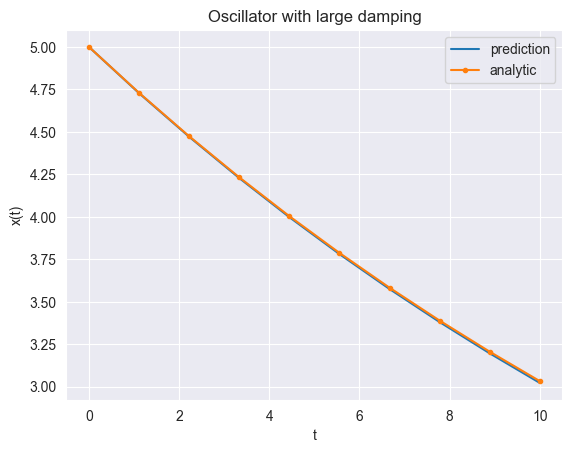

In [213]:
# Define the parameters
input_size = 1  # Dimension of the input (x)
hidden_size = 60  # Number of units in the hidden layer
output_size = 1  # Dimension of the output (u)
initial_value = 5  # f(a) = initial_value - amplitude
initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 10
number_of_time_steps = 10


# Create an instance of the PINN model
model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, last_point_of_the_domain, 
                            number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # in article lr=0.001 as well

# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss = pinn_loss(model, x_collocation, x0, mass, b, k)

    # Perform optimization
    loss.backward()
    optimizer.step()

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(initial_point_of_the_domain, last_point_of_the_domain, 
                            number_of_time_steps).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred = u_pred_tensor.numpy()
    
u_analytic = analytic_solution(x_test, x0, k, b)

plt.plot(x_test, u_pred, label='prediction')
plt.plot(x_test, u_analytic, label='analytic', marker='.')
plt.legend()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Oscillator with large damping')
plt.show()

## Comparison with numerical RK4 solution

In [215]:
def second_order_ode(t, x, k, mass, b):
    dxdt = x[1]  # dx/dt = v
    dvdt = -(k/mass)*x[0] - (b/mass)*x[1]  # x'' = -(k/m)*x - (b/m)*v
    return [dxdt, dvdt]

In [216]:
# Define parameters
mass = 1  # Mass
k = 0.5  # Spring constant
b = 10  # Damping coefficient

# Initial conditions
x0 = 5  # Initial displacement
v0 = 0  # Initial velocity
initial_conditions = [x0, v0]

# Time span
t_span = (initial_point_of_the_domain, last_point_of_the_domain)  # Solve from t=0 to t=10

# Solve the ODE
sol = solve_ivp(second_order_ode, t_span, initial_conditions, args=(k, mass, b), 
                t_eval=np.linspace(initial_point_of_the_domain, last_point_of_the_domain, number_of_time_steps))

# Extract solution
t = sol.t
x = sol.y[0]  # Displacement

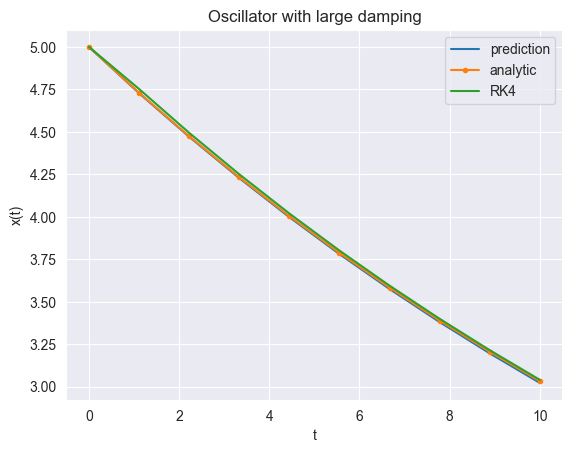

In [217]:
plt.plot(x_test, u_pred, label='prediction')
plt.plot(x_test, u_analytic, label='analytic', marker='.')
plt.plot(t, x, label='RK4')
plt.legend()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Oscillator with large damping')
plt.show()

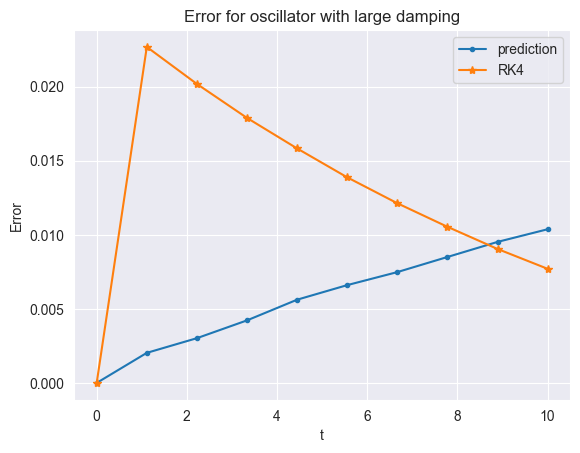

In [218]:
plt.plot(x_test, abs(u_pred-u_analytic), label='prediction', marker='.')
plt.plot(t, abs(x.reshape(-1,1)-u_analytic), label='RK4', marker='*')
plt.legend()
plt.xlabel('t')
plt.ylabel('Error')
plt.title('Error for oscillator with large damping')
plt.show()

## Grid effect RK4 vs ANN

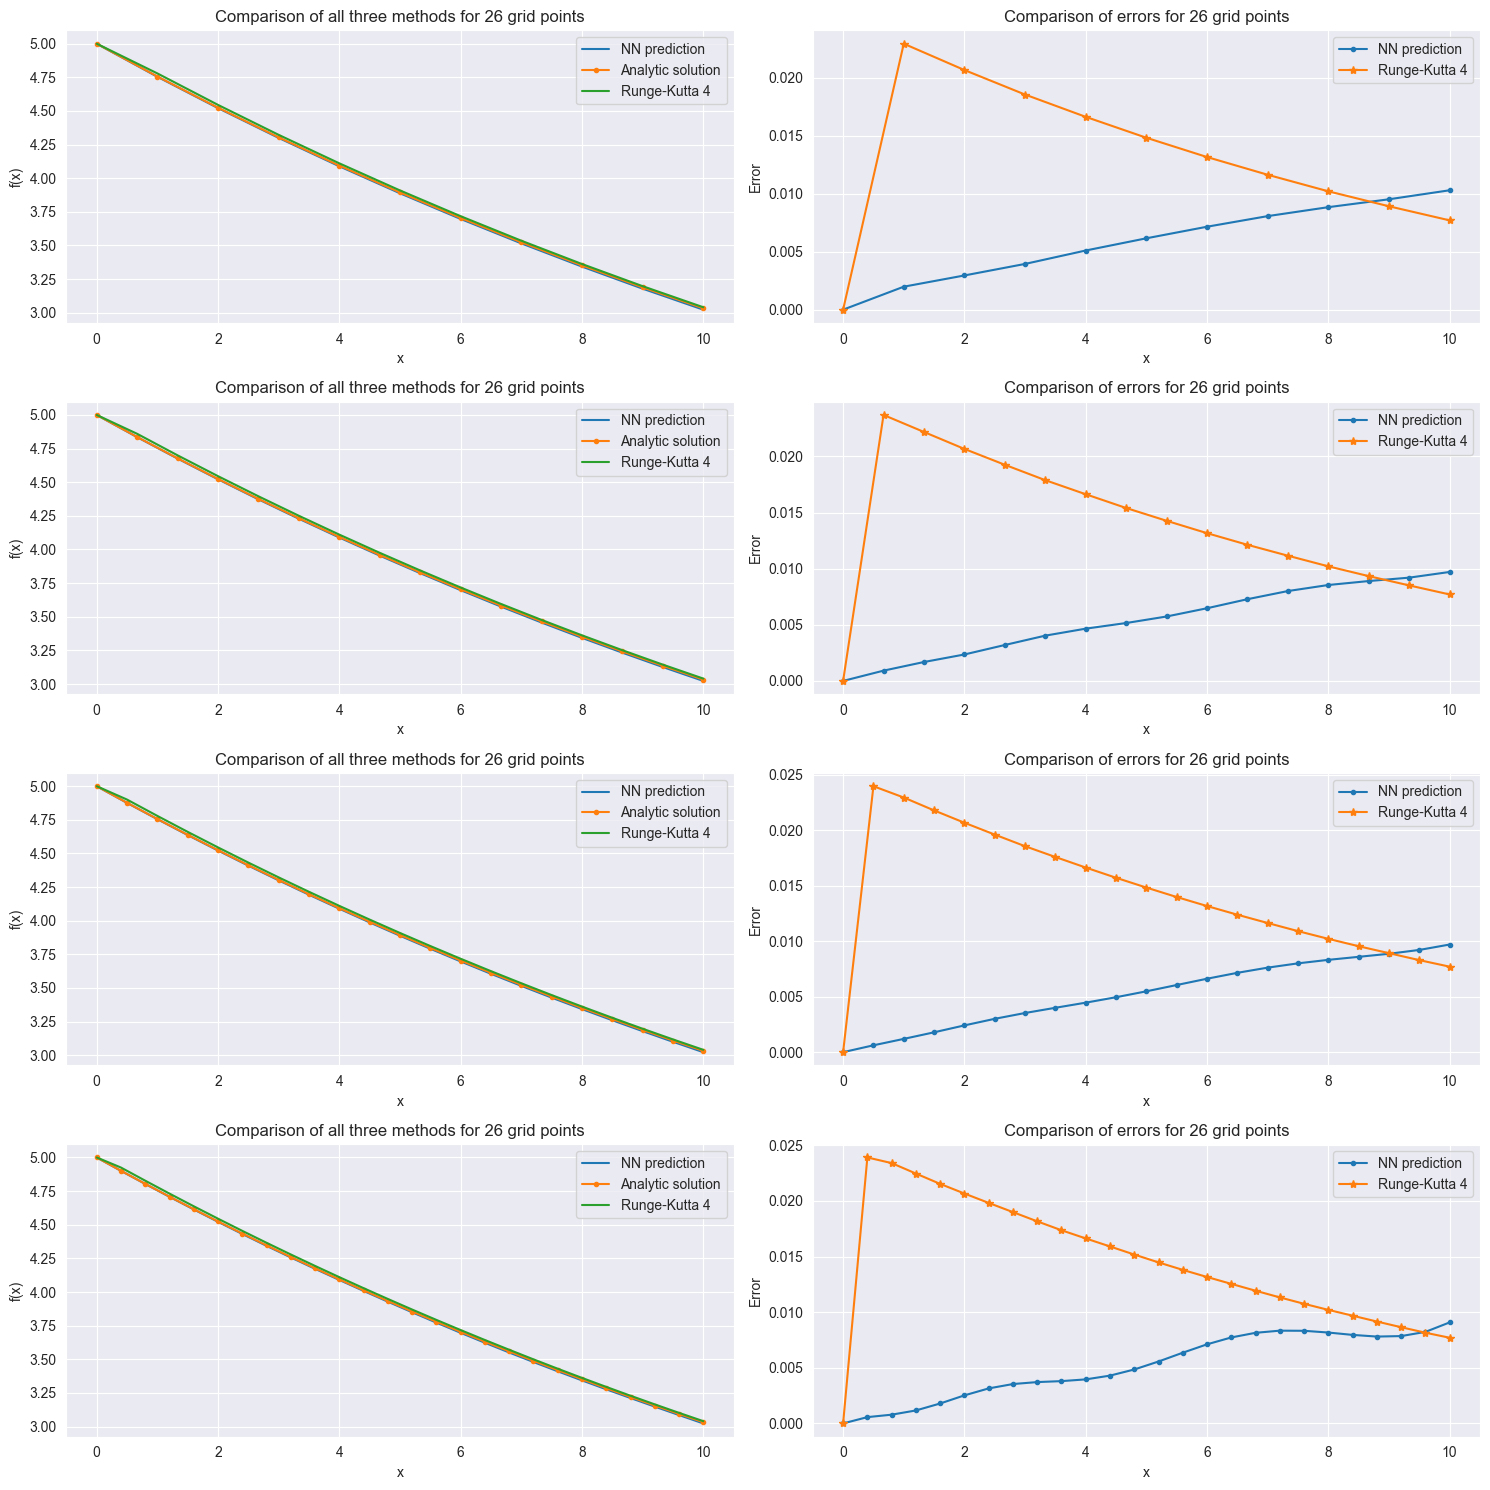

In [219]:
# diffent size of grid points between a and b.
M = [11, 16, 21, 26]  # number of time steps
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)
initial_value = 5 # f(a) = initial_value - amplitude
initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 10

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for ind,m in enumerate(M):
    # NN
    # Create an instance of the PINN model
    model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(initial_point_of_the_domain, last_point_of_the_domain, m).reshape(-1, 1) # domain (0,1) - m_ sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 3000 # as in the article
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, x0, mass, b, k)

        # Perform optimization
        loss.backward()
        optimizer.step()


    # Evaluate the trained model
    with torch.no_grad():
        # Generate test data
        x_test = np.linspace(initial_point_of_the_domain, last_point_of_the_domain, m).reshape(-1, 1)

        # Convert test data to PyTorch tensor
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

        # Compute the neural network's predictions
        u_pred_tensor = model(x_test_tensor)

        # Convert predictions to numpy array
        u_pred = u_pred_tensor.numpy()

    # Compute the analytic solution for comparison
    u_analytic = analytic_solution(x_test, x0, k, b)
    
    axs[ind,0].plot(x_collocation, u_pred, label='NN prediction')
    axs[ind,0].plot(x_collocation, u_analytic, label='Analytic solution', marker=".")
    
    
    # RK solution - numeric
    # Solve ODE using Runge-Kutta 4 (solve_ivp from scipy)
    # Time span
    t_span = (initial_point_of_the_domain, last_point_of_the_domain)  # Solve from t=0 to t=10
    x0 = 5  # initial displacement
    v0 = 0  # initial velocity
    initial_conditions = [x0, v0]

    # Solve the ODE
    sol = solve_ivp(second_order_ode, t_span, initial_conditions, args=(k, mass, b), 
                    t_eval=np.linspace(initial_point_of_the_domain, last_point_of_the_domain, m))

    # Extract solution
    t = sol.t
    x = sol.y[0]  # Displacement
    
    axs[ind,0].plot(t, x, label='Runge-Kutta 4')
    axs[ind,0].legend()
    axs[ind,0].set_title('Comparison of all three methods for {} grid points'.format(m_))
    axs[ind,0].set_xlabel('x')
    axs[ind,0].set_ylabel('f(x)')
    
    axs[ind,1].plot(x_collocation, abs(u_pred-u_analytic), label='NN prediction', marker=".")
    axs[ind,1].plot(sol.t, abs(sol.y[0]-[element for sublist in u_analytic for element in sublist]), label='Runge-Kutta 4', marker="*")
    axs[ind,1].legend()
    axs[ind,1].set_title('Comparison of errors for {} grid points'.format(m_))
    axs[ind,1].set_xlabel('x')
    axs[ind,1].set_ylabel('Error')
    fig.tight_layout()

## For different activation function ??